# Creating optical water types from hyperspectral PACE data
**Author:** Ryan Vandermeulen (NOAA)</br>
Last updated: January 26, 2026

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link] [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Jupyter_Hub-orange?style=for-the-badge)][jupyter-link]
<!--
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/water_classification.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> 
-->

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/water_classification.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/water_classification.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/water_classification.ipynb

## Introduction

In a previous tutorial, we explored how to analyze sensitive metrics of change in the ocean using R$_{rs}$ and derived indices.

We’re going to stay on that same theme, but take a slightly different approach. **Optical water type (OWT) classification** provides a way to isolate distinct reflectance signatures and track them across time and space. A few years ago, our astute NOAA colleague Jianwei Wei compiled a large database of in situ and simulated hyperspectral reflectance data and, using k-means clustering, statistically determined that marine water masses around the globe generally fall into 23 distinct optical water classes (see below). You can also check it out in [**Wei et al. (2022)**](https://doi.org/10.1016/j.rse.2022.113233). 


![23 optical water types](https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/Supporting_files/OWT.jpg)


Using the average shape of these optical water classes as a reference point, we can essentially "match" our hyperspectral PACE data at every pixel, and assign it to one of those 23 shapes. The key advantage here is that we can put our data into a rigid and consistent classification system that clearly demarks areas with specific optical features. It's like being on a kitchy tour group and having everyone wear matching bright t-shirts so you can find one another... sort of. Note, this is not currently a distributed PACE data product, but it has been generating interest among our scientists at NOAA Fisheries, so now, we extend this capability to you all!
 
So here's the plan. We're going to load those 23 distinct reference spectra and try our hand at a very simple, but effective, spectral matching technique. We will then assign each pixel in a PACE image to a water class number and voila! - We will have the ability to generate a mapped image of hyperspectral optical water types.

Let's dive in and mess around with some PACE data then. By the end of this section, you will have:

> 1. Calculated the "cosine distance" between a spectral reference library against PACE data
> 2. Assigned Optical Water Types (OWT) from PACE data and made a map
> 3. Compared PACE spectra against the reference OWT spectra
> 4. Do your own k-means clustering!

## *Are you ready?*

## Let's go get some data first

In [25]:
import earthaccess
import xarray as xr
auth = earthaccess.login()
if not auth.authenticated:
    auth.login(strategy="interactive", persist=True)

Note, just to get a feel for the differences in data handling, let's explore a standard mapped **Level-3** file instead of the individual satellite scene (*Level-2*) that we explored in the $R_{rs} $ tutorial. There are small differences that will make you want to bang your head agaisnt the wall if you're not familiar with them. I have banged my head for you, and now I share what has been learned:

In [26]:
# This gives the shortnames for all of the PACE datasets
#results = earthaccess.search_datasets(instrument="oci")
#for item in results:
#    summary = item.summary()
#    print(summary["short-name"])

PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_UVAI_UAA_NRT
PACE_OCI_L2_UVAI_UAA
PACE_OCI_L2_AER_UAA_NRT
PACE_OCI_L2_AER_UAA
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_AOP
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_CLOUD
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_LANDVI_NRT
PACE_OCI_L2_LANDVI
PACE_OCI_L2_BGC
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L2_PAR
PACE_OCI_L2_SFREFL_NRT
PACE_OCI_L2_SFREFL
PACE_OCI_L3B_AOT_NRT
PACE_OCI_L3B_AOT
PACE_OCI_L3B_AVW_NRT
PACE_OCI_L3B_AVW
PACE_OCI_L3B_CARBON
PACE_OCI_L3B_CARBON_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_CHL
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_KD
PACE_OCI_L3B_FLH_NRT
PACE_OCI_L3B_FLH
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_IOP
PACE_OCI_L3B_LANDVI_NRT
PACE_OCI_L3B_LANDVI
PACE_OCI_L3B_PIC_NRT
PACE_OCI_L3B_PIC
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_POC
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_PAR
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3B_RRS
PACE_OCI_L3B_SFREFL_NRT
PACE_OCI_L3B_SFREFL
PACE_OCI_L3M_UV

In [18]:
#(west, south, east, north)
bbox = (-76.903, 37.873, -75.608, 39.659)
import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_SFREFL",
    temporal = ("2025-07-22", "2025-07-22"),
    bounding_box = bbox
)
fileset = earthaccess.open(results);

print(fileset)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250722T173005.L2.SFREFL.V3_1.nc>]


A few key differences to note:

> - short_name: Product based (e.g. RRS, CHL) in Level-3, not the product suite (e.g., AOP, BGC) like in Level-2.
> - bounding_box: Not necessary at this stage, as Level-3 files are inherently global
> - granule_name: *.YR.*,*.MO.*,*.8D.*,*.DAY.* for time; *.0p1deg.*, *.9KM.*, *.4KM.* for spatial

Alright, let's open this up! Libraries first!

In [19]:
# Load Libraries 
import numpy as np
import xarray as xr
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.integrate import trapezoid

In [20]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [27]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 122, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/25)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    clat           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    elat           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    csol_z         (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB dask.array<chunksize=(32, 256, 40), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250722T173005.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data2/sdpsoper/vdc/vpu21/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -92.374756
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9688000679016113
    geospatial_bounds:                 POLYGON ((-59.96334 45.67412, -92.3747...

In [29]:
# Extract hyperspectral Rhos
rhos_array = ds['rhos']  # shape: (wavelength, lat, lon)
wavelength = rhos_array['wavelength_3d'].values  # should be in nm

# Spatial Subset (optional)-76.903, 37.873, -75.608, 39.659
lat_bounds = slice(39.659, 37.873)
lon_bounds = slice(-76.903, -75.608)
rhos_subset = rhos_array.sel(lat=lat_bounds, lon=lon_bounds)

KeyError: "'lat' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'wavelength_3d': 122, 'number_of_lines': 1710, 'pixels_per_line': 1272})"

## Subsetting

To make things more efficient, let's subset a region of interest around U.S. side of the North Atlantic ocean.

In [22]:
# Spatial Subset (optional)-76.903, 37.873, -75.608, 39.659
lat_bounds = slice(39.659, 37.873)
lon_bounds = slice(-76.903, -75.608)
rrs_subset = rrs_array.sel(lat=lat_bounds, lon=lon_bounds)

NameError: name 'rrs_array' is not defined

## Let's make a match!

Here, we bring in our 23 reference spectra from Wei et al. (2022). They are provided at 1 nm resolution, while PACE is at ~2.5 nm resolution, so first we'll have to extract and match those to the PACE wavelengths. Then we'll proceed to make the cosine distance calculation to find the closest spectral match. Without going into too much detail, the cosine distance measures the magnitude of the dot product between the PACE spectrum and the 23 reference spectra - the lowest value = the closest match.

In [10]:
# Load reference spectra
url = (
    "https://raw.githubusercontent.com/"
    "fish-pace/2025-tutorials/main/"
    "Supporting_files/Hyperspectral_nRrs.csv"
)
nRrs_ref = pd.read_csv(url)

# Match satellite and reference wavelengths
sat_wavelengths_str = [str(int(w)) for w in wavelengths]
ref_columns = nRrs_ref.columns
common_wavelengths = sorted(set(sat_wavelengths_str).intersection(ref_columns), key=int)
print(f"Using {len(common_wavelengths)} common wavelengths: {common_wavelengths}")

# Extract matched reference spectra
ref = nRrs_ref[common_wavelengths].values

# Subset satellite reflectance to common wavelengths
common_wavelengths_float = [float(w) for w in common_wavelengths]
rrs_subset_common = rrs_subset.sel(wavelength=common_wavelengths_float)

# Normalize satellite data
norm = np.sqrt((rrs_subset_common ** 2).sum(dim='wavelength'))
rrs_norm = rrs_subset_common / norm

# Normalize reference spectra
ref_norm = ref / np.linalg.norm(ref, axis=1, keepdims=True)

# Flatten satellite data
rrs_flat = rrs_norm.stack(pix=('lat', 'lon')).transpose('pix', 'wavelength').values

# Compute cosine distance
dot_products = np.dot(rrs_flat, ref_norm.T)
cosine_distances = 1 - dot_products

# Assign water class with smallest distance (index + 1 for 1-based)
mask= np.where(~np.isnan(cosine_distances).all(axis=1))[0] #create a mask of all NON- nan values (don't want to classify NaNs)
class_ids = np.full((cosine_distances.shape[0],),np.nan) # create an array of nan values in the desired output shape

# the first index is [0] so we add +1 since the first water class is "1"
class_ids[mask] = np.argmin(cosine_distances[mask],axis=1)+1 # fill in NON-nan values of class ID using the mask

# Reshape to 2D map
lat_dim, lon_dim = rrs_norm.sizes['lat'], rrs_norm.sizes['lon']
class_map = xr.DataArray(class_ids.reshape(lat_dim, lon_dim), dims=('lat', 'lon'),
    coords={'lat': rrs_norm['lat'], 'lon': rrs_norm['lon']}, name='water_class')

Using 136 common wavelengths: ['400', '403', '405', '408', '410', '413', '415', '418', '420', '422', '425', '427', '430', '432', '435', '437', '440', '442', '445', '447', '450', '452', '455', '457', '460', '462', '465', '467', '470', '472', '475', '477', '480', '482', '485', '487', '490', '492', '495', '497', '500', '502', '505', '507', '510', '512', '515', '517', '520', '522', '525', '527', '530', '532', '535', '537', '540', '542', '545', '547', '550', '553', '555', '558', '560', '563', '565', '568', '570', '573', '575', '578', '580', '583', '586', '588', '613', '615', '618', '620', '623', '625', '627', '630', '632', '635', '637', '640', '641', '642', '643', '645', '646', '647', '648', '650', '651', '652', '653', '655', '656', '657', '658', '660', '661', '662', '663', '665', '666', '667', '668', '670', '671', '672', '673', '675', '676', '677', '678', '679', '681', '682', '683', '684', '686', '687', '688', '689', '691', '692', '693', '694', '696', '697', '698', '699']


## Mappy time

Now, let's make a map of the optical water type for our single monthly image. Some more important distinctions here: In Level-3 files, "lat" is latitude and "lon" is longitude. These are actually 1D arrays, since the Level-3 files are on a standard mapped grid by which a straight horizontal line = parellel and straight vertical line = meridian. No biggy, but if you try to lift code from reading in a Level-2 file, it will get a little angry without some minor swapouts. 

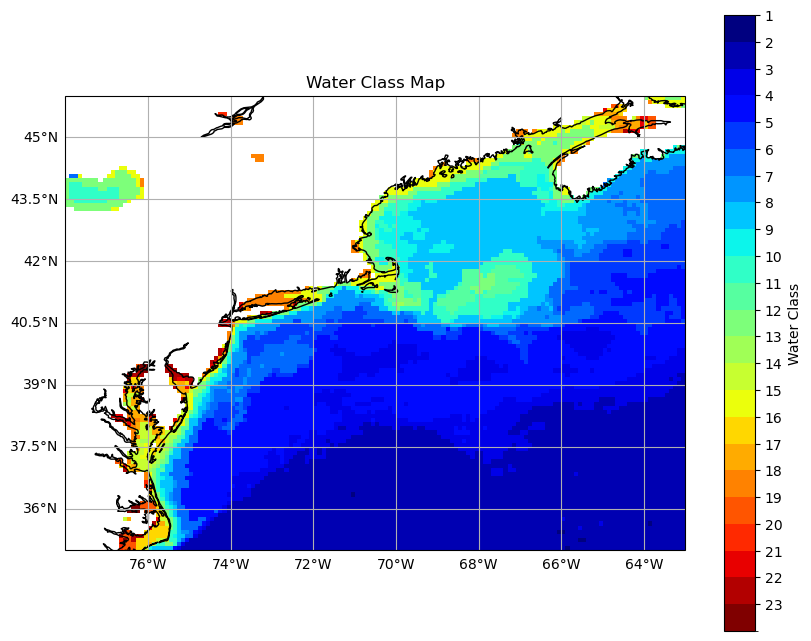

In [7]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define a colormap with 23 distinct colors (you can customize this list)
colors = plt.cm.jet(np.linspace(0, 1, 23))  # 23 colors from the 'jet' colormap
cmap = ListedColormap(colors)

# Create a BoundaryNorm to discretize the colorbar and stretch it across all 23 classes
# Note: If you have 23 classes, you need 24 boundaries because each class is an interval between two boundaries.
boundaries = np.arange(1, 25)  # 1 through 24 boundaries, plus one extra boundary for the last class
norm = BoundaryNorm(boundaries, ncolors=23, clip=True)

# Plot the class_map with discretized colors
c = ax.pcolormesh(class_map.lon, class_map.lat, class_map,cmap=cmap, shading='auto', norm=norm)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
cbar = plt.colorbar(c, ax=ax, label='Water Class')
cbar.set_ticks(np.arange(1, 24))  # Show ticks for whole numbers (1 through 23)
cbar.ax.invert_yaxis()  # Invert colorbar to match class order 
plt.title('Water Class Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## But what does it all mean?

Let's put some context to these water classes. First, we're going to take the mean + std of all the PACE spectra that fall within each specific optical water class. Basically, we'll create a mask, and then pull out all the PACE spectra that meet certain criteria. 

In [8]:
# Ensure number of classes matches your setup
n_classes = 23
n_bands = len(common_wavelengths)

# Reuse your class map color scheme
colors = plt.cm.jet(np.linspace(0, 1, n_classes))
cmap = ListedColormap(colors)
boundaries = np.arange(1, n_classes + 2)
norm = BoundaryNorm(boundaries, ncolors=n_classes, clip=True)

# First "flatten" the arrays for mean + std calculation prep
rrs_flat = rrs_norm.stack(pix=('lat', 'lon')).transpose('pix', 'wavelength').values
class_vals = class_map.stack(pix=('lat', 'lon')).values  

Just a quick pause, becuase "flattening" confused me a bit at first. Here's what is going on:

> rrs_norm originally has shape (wavelength, lat, lon)
> rrs_norm.stack(pix=('lat', 'lon')) combines the lat and lon dimensions into a single new dimension called pix. Now the shape is (wavelength, pix)
> .transpose('pix', 'wavelength') rearranges it to (pix, wavelength) — now each row is a pixel, each column is a wavelength
> .values converts the xarray DataArray into a plain NumPy array.

After stacking/flattening, you can iterate over pixels or use vectorized operations easily without worrying about 2D/3D indexing. It makes the subsequent calculations more efficient, as opposed to looping over every pixel. Okay, back to our program:

In [9]:
# Compute empty arrays to fill in
mean_spectra = np.full((n_classes, n_bands), np.nan)
std_spectra = np.full((n_classes, n_bands), np.nan)

# Compute mean spectra + std from satellite
for class_id in range(1, n_classes + 1):
    mask = (class_vals == class_id)
    if np.any(mask):
        spectra = rrs_flat[mask]  # shape (n_pixels_in_class, bands)
        mean_spectra[class_id - 1] = np.nanmean(spectra, axis=0)
        std_spectra[class_id - 1] = np.nanstd(spectra, axis=0)

## Comparing PACE data with reference data

Finally, we're going to compare the mean satellite data spectral shapes against the reference library. This is a bit of a sanity check, but also allows you to get an idea of the variance within each class. 

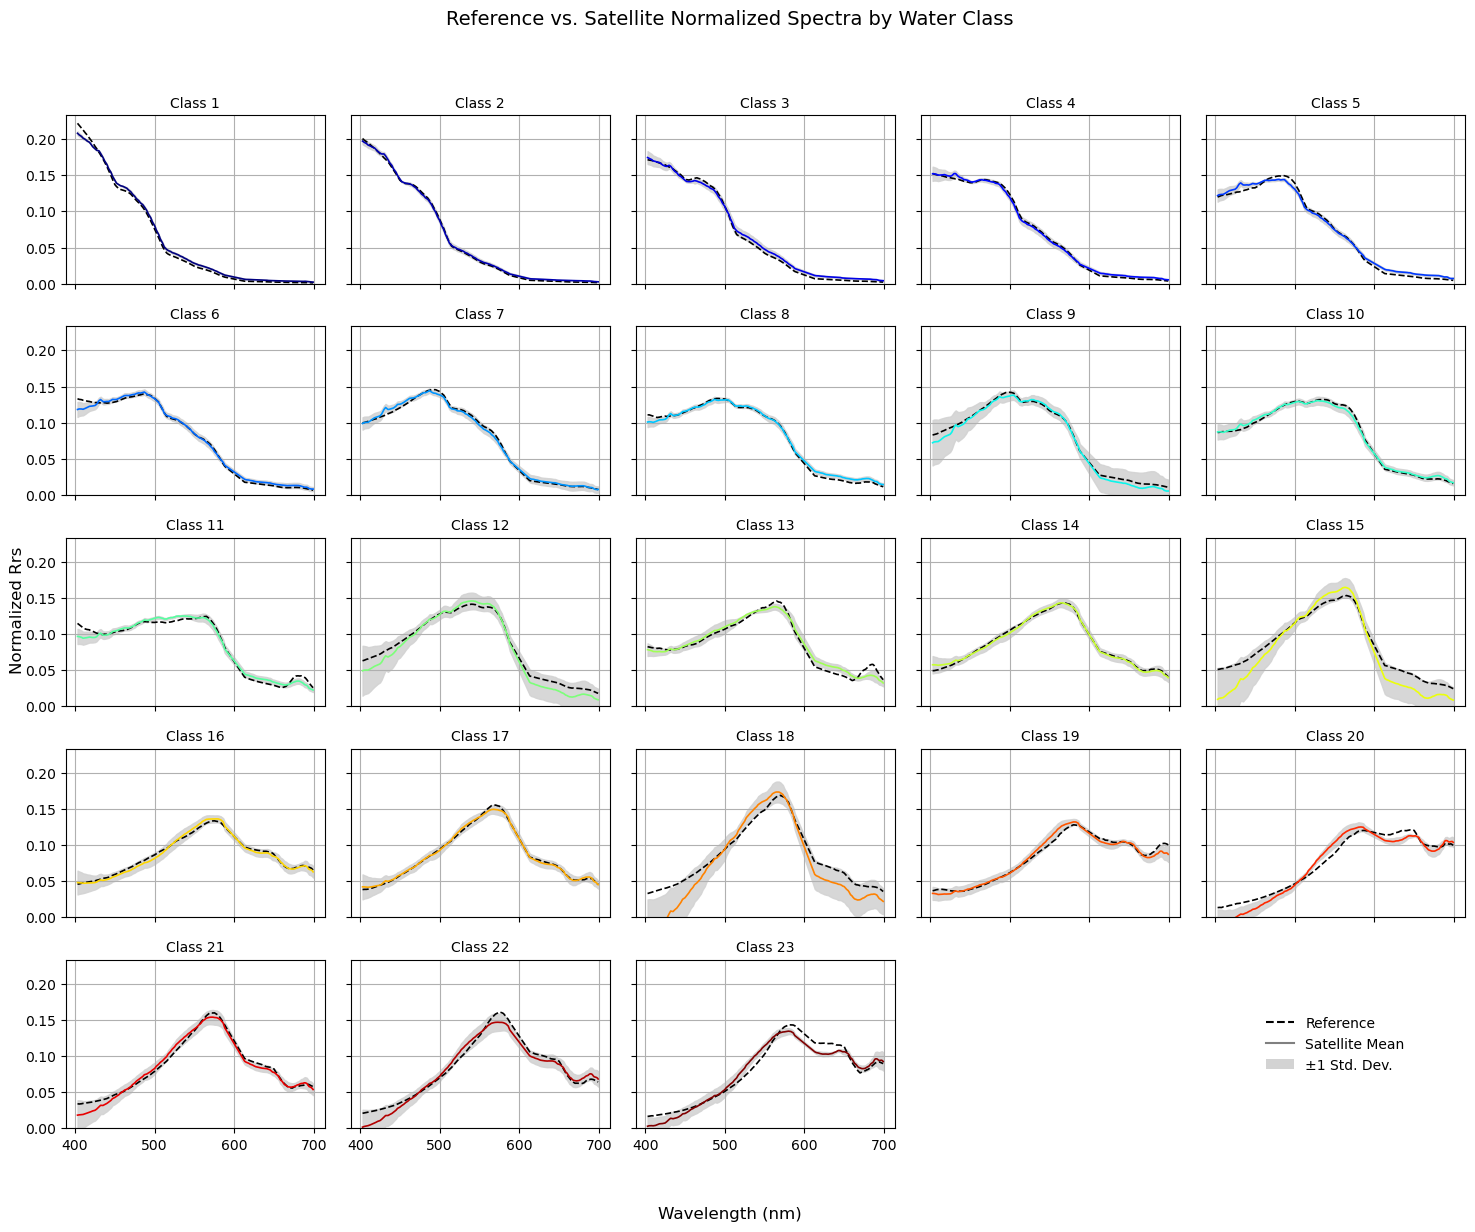

In [10]:
wavelengths_plot = np.array(common_wavelengths_float)

# Setup subplot grid
n_classes = 23
cols = 5
rows = int(np.ceil(n_classes / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 2.5), sharex=True, sharey=True)
axes = axes.flatten()

# Plotting loop
for class_id in range(1, 24):
    ax = axes[class_id - 1]
    color = colors[class_id - 1]
    
    ref_spec = ref_norm[class_id - 1]
    sat_spec = mean_spectra[class_id - 1]
    sat_std = std_spectra[class_id - 1]
    
    if not np.any(np.isnan(sat_spec)):
        ax.fill_between(wavelengths_plot, sat_spec - sat_std, sat_spec + sat_std, color='lightgray', alpha=0.9, label='±1 Std. Dev.')
    ax.plot(wavelengths_plot, ref_spec, '--', color='black', linewidth=1.2, label='Reference')
    ax.plot(wavelengths_plot, sat_spec, '-', color=color, linewidth=1.2, label='Satellite')
    ax.set_ylim(bottom=0)
    ax.set_title(f'Class {class_id}', fontsize=10)
    ax.grid(True)
    ax.label_outer()

# Remove unused subplots and use one for legend
for i in range(n_classes, len(axes)):
    fig.delaxes(axes[i])

# Create a dummy legend in the bottom-right corner (last empty subplot position)
legend_ax = fig.add_subplot(rows, cols, cols * rows)  # last cell
legend_ax.axis('off')  # Hide axis
legend_lines = [Line2D([0], [0], linestyle='--', color='black', label='Reference'),
    Line2D([0], [0], linestyle='-', color='gray', label='Satellite Mean'),
    Patch(facecolor='lightgray', edgecolor='none', label='±1 Std. Dev.')]
legend_ax.legend(handles=legend_lines, loc='center', fontsize=10, frameon=False)

# Global labels
fig.suptitle("Reference vs. Satellite Normalized Spectra by Water Class", fontsize=14)
fig.supxlabel("Wavelength (nm)")
fig.supylabel("Normalized Rrs")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Bring it full circle

Just for giggles, let's compute AVW by "hand" and compare it to the water mass classification so we can compare the two. Note, it is a pretty small lift to just compute AVW, if you ever want to avoid reading it in as a separate product. By default, it uses the visible range of the spectrum (400 - 700 nm), as does the OWT classification. One advatnage of calculating AVW independently is that you can set your own custom range of wavelengths if you are interested in extending the spectrum (e.g. 350 - 710).

In [11]:
# Subset wavelengths
rrs_subset_range = rrs_subset.sel(wavelength=slice(400, 700))

# Compute AVW: sum(Rrs) / sum(Rrs / wavelength)
avw = rrs_subset_range.sum(dim='wavelength') / (rrs_subset_range / rrs_subset_range['wavelength']).sum(dim='wavelength')

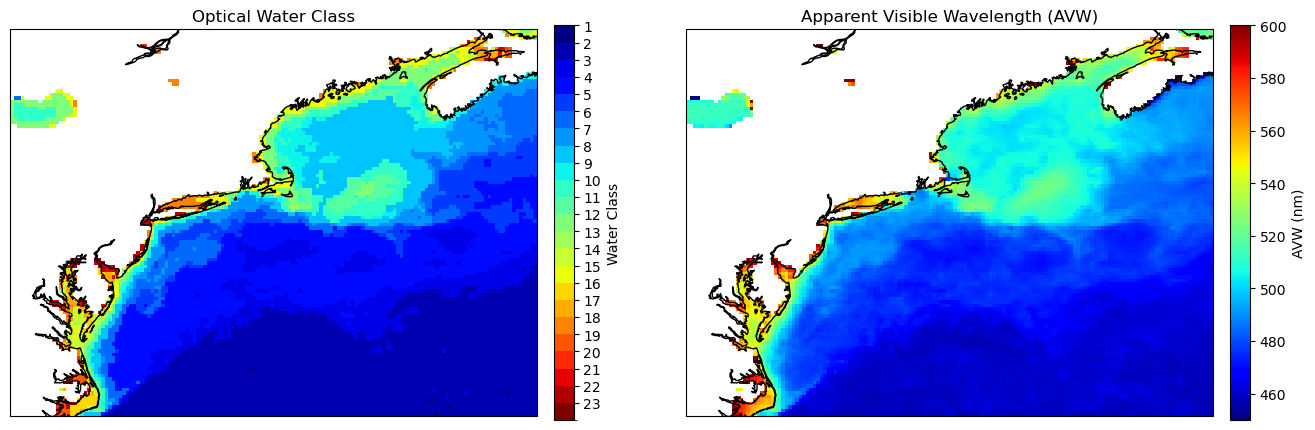

In [19]:
# User-defined AVW range
avw_min = 450
avw_max = 600

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Class map
colors = plt.cm.jet(np.linspace(0, 1, 23))
cmap_classes = ListedColormap(colors)
boundaries = np.arange(1, 25)  # 23 classes → 24 boundaries
norm_classes = BoundaryNorm(boundaries, ncolors=23, clip=True)

c1 = ax1.pcolormesh(class_map.lon, class_map.lat, class_map, cmap=cmap_classes, norm=norm_classes, shading='auto')
ax1.coastlines()
ax1.set_title('Optical Water Class')
cbar1 = plt.colorbar(c1, ax=ax1, ticks=np.arange(1, 24), fraction=0.035, pad=0.03)
cbar1.set_label('Water Class')
cbar1.ax.invert_yaxis()

# AVW map 
c2 = ax2.pcolormesh(avw.lon, avw.lat, avw, cmap='jet', vmin=avw_min, vmax=avw_max, shading='auto')
ax2.coastlines()
ax2.set_title('Apparent Visible Wavelength (AVW)')
cbar2 = plt.colorbar(c2, ax=ax2, fraction=0.035, pad=0.03)
cbar2.set_label('AVW (nm)')
plt.show()

You can that the maps largely mirror one another, but each have distinct utility. As a quick guide: 

> - OWTs give you a more concrete classification of spectral shape across the globe. For example, the R$_{rs}$ spectra contained in "Class 16" will more precisely resemble one another across multiple water types relative to conditions where "AVW = 550 nm."

> - AVW is gradational in time/space and has physical units, so it would be more useful, for example, in a time-series analysis where you can say that color is changing by XX nm / year. Given the nature of the AVW calculation as a weighted harmonic mean, a higher/lower shift in AVW values unequivicoally represents a proportional shift in the weighted "color" of the water, regardless of absolute spectral shape.


## Doing your own clustering

![After_all](https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/Supporting_files/lotr-why-shouldnt-i.gif)!

Sometimes the best way to explore your data is to let the data speak for itself. Instead of relying solely on predefined reference optical water types, you can use unsupervised clustering to group pixels based spectral shapes in your image.  Here we’ll use k-means clustering, a simple but powerful method to discover natural groupings in your spectra. Here, each pixel’s spectrum is treated as a vector in high-dimensional wavelength space. Pixels with similar spectral shapes get assigned to the same cluster. If we normalize each spectrum (as we did previously), the clustering focuses on shape differences, not absolute magnitude. You can opt to put raw (non-normalized) reflectance values as input as well, but *sometimes* you end up getting a lot of similar shapes put into different clusters. Try both :-) 

Okay, let's walk it through. Most of this is just getting everything into the right format. Once again, we have to “flatten” the array, turning our 2D spatial image into a 2D matrix of pixels × wavelengths. Each row will represent a single pixel’s spectrum, and each column a wavelength. This makes it easy for k-means to process the data. We also need to mask out any pixels with missing values, as NaNs can break the clustering. Once that’s done, the pixels are ready to be fed into the k-means algorithm. 

> Tip: Start with a small number of clusters (e.g., 5–10) to get a feel for the data, then experiment with more to capture finer distinctions.
> 
> Tip2: Try toggling use_normalized=True or use_normalized=False to use normalized v. non-normalized spectra, respectively and see how it changes your clustering.

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

n_clusters = 10 
use_normalized = True  # Set True for normalized spectra, False for raw spectra

# Choose which data to use and get rid of NaNs
rrs_flat = rrs_norm.stack(pix=('lat', 'lon')).transpose('pix', 'wavelength').values
rrs_flat_nonnorm = rrs_subset_common.stack(pix=('lat', 'lon')).transpose('pix', 'wavelength').values
X_input = rrs_flat if use_normalized else rrs_flat_nonnorm
mask = np.where(~np.isnan(X_input).any(axis=1))[0]
X_scaled = X_input[mask, :]

# Run K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
cluster_means = np.array([X_scaled[kmeans_labels == k].mean(axis=0) for k in range(n_clusters)])

## Making things intuitive

So, K-means randomly initializes 10 cluster centroids. Iteratively, it assigns each pixel to the nearest centroid. The numbers themselves (0,1,2…) do not have any meaning. They are just the order in which the centroids were stored internally. That is a little confusing if you look at a map and Cluster 1 is coastal water and Cluster 2 is in the blue ocean. So what can we do?

Jianwei's approach was to sort the clusters in descending order of Rrs443/Rrs551. We could also use AVW here, but to keep consistent with his approach, let's use that. It's just a way of ordering the clusters so that the tendency is such that more blue waters will have lower cluster numbers, and more coastal waters will have higher cluster numbers. At least it makes it intuitive. 

In [17]:
# Reorder clusters by cluster-mean nRrs(443)/nRrs(551): descending order
wavelengths_plot = np.array(common_wavelengths_float)
i443 = np.argmin(np.abs(wavelengths_plot - 443))
i551 = np.argmin(np.abs(wavelengths_plot - 551))
ratios = cluster_means[:, i443] / cluster_means[:, i551]
order = np.argsort(-ratios)

# We have the index, now let's actually reorder the cluster means + labels for plotting
cluster_means_ordered = cluster_means[order, :]
kmeans_labels_ordered = np.zeros_like(kmeans_labels)
for new_idx, old_idx in enumerate(order):
    kmeans_labels_ordered[kmeans_labels == old_idx] = new_idx

## Let's see how it looks

Let's make a map akin to what we did above to show how our clusters are distributed. Beside that, we'll put a 2D line plot showcasing the mean (+stddev) of the spectral shapes within each cluster.

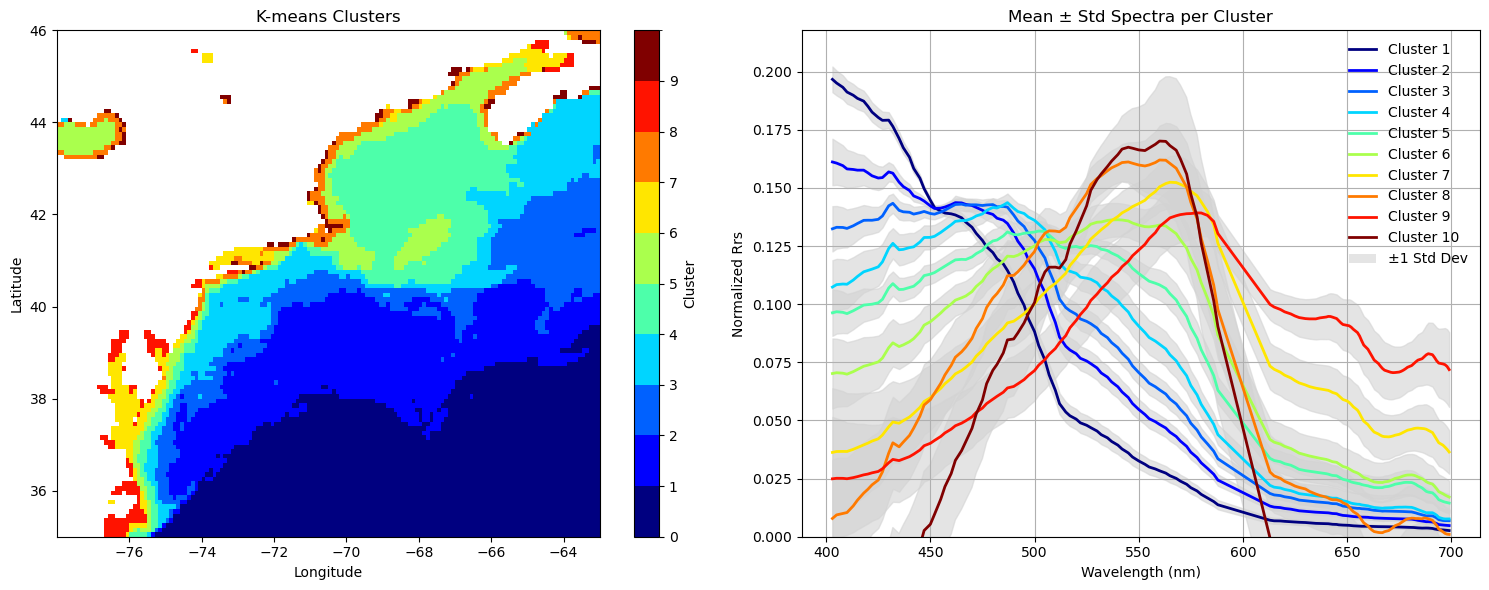

In [18]:
# Create cluster map for plotting
cluster_map = np.full(X_input.shape[0], np.nan)
cluster_map[mask] = kmeans_labels_ordered  # pixels labeled 0..n_clusters-1 in your desired order
cluster_map_2d = cluster_map.reshape(rrs_subset.sizes['lat'], rrs_subset.sizes['lon'])
cluster_da = xr.DataArray(cluster_map_2d, dims=('lat','lon'), coords={'lat': rrs_subset['lat'], 'lon': rrs_subset['lon']}, name='kmeans_cluster')
# Colormap setup
colors = plt.cm.jet(np.linspace(0, 1, n_clusters))
cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(0, n_clusters+1), ncolors=n_clusters, clip=True)

# Plotting: side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15,6))

# Panel 1: Cluster map
im = axes[0].pcolormesh(cluster_da.lon, cluster_da.lat, cluster_da, cmap=cmap, shading='auto', norm=norm)
axes[0].set_title('K-means Clusters')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(im, ax=axes[0], label='Cluster', ticks=np.arange(0, n_clusters))

# Panel 2: Mean ± std spectra
ax = axes[1]
for cluster_id in range(n_clusters):
    cluster_pixels = X_scaled[kmeans_labels_ordered == cluster_id, :]
    if cluster_pixels.size == 0:
        continue
    mean_spec = cluster_pixels.mean(axis=0)
    std_spec = cluster_pixels.std(axis=0)
    # Plot shaded ±1 std and mean line
    ax.fill_between(wavelengths_plot, mean_spec-std_spec, mean_spec+std_spec, color='lightgray', alpha=0.6)
    ax.plot(wavelengths_plot, mean_spec, color=colors[cluster_id], lw=2, label=f'Cluster {cluster_id+1}')
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Normalized Rrs" if use_normalized else "Rrs")
ax.set_title("Mean ± Std Spectra per Cluster")
ax.grid(True)
ax.set_ylim(bottom=0)
# Legend
handles = [Line2D([0],[0], color=colors[i], lw=2, label=f'Cluster {i+1}') for i in range(n_clusters)]
handles.append(Patch(facecolor='lightgray', edgecolor='none', alpha=0.6, label='±1 Std Dev'))
ax.legend(handles=handles, fontsize=10, frameon=False)
plt.tight_layout()
plt.show()

## That's a wrap!

There you have it! You are now an OWT. You are now entitled to cut to the front of the line in all ocean color related events. You may raise your chin high and look down from your perch of wisdom to the others who do not possess the power of water mass classification and indexing. Enjoy the rest of your day, majesty. 